In [546]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)

# 1. Loading the dataset:

In [547]:
df = pd.read_csv("train.csv")
y = df['Survived'] 
X = df.drop(["Survived"], axis=1)

In [548]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Display dataset

In [549]:
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

## Display train data

In [550]:
X_train.head()

PassengerId  Pclass                             Name     Sex    Age  \
298          299       1            Saalfeld, Mr. Adolphe    male    NaN   
884          885       3           Sutehall, Mr. Henry Jr    male  25.00   
247          248       2  Hamalainen, Mrs. William (Anna)  female  24.00   
478          479       3        Karlsson, Mr. Nils August    male  22.00   
305          306       1   Allison, Master. Hudson Trevor    male   0.92   

     SibSp  Parch           Ticket      Fare    Cabin Embarked  
298      0      0            19988   30.5000     C106        S  
884      0      0  SOTON/OQ 392076    7.0500      NaN        S  
247      0      2           250649   14.5000      NaN        S  
478      0      0           350060    7.5208      NaN        S  
305      1      2           113781  151.5500  C22 C26        S

## Display test data

In [551]:
X_test.head()

PassengerId  Pclass                                               Name  \
709          710       3  Moubarek, Master. Halim Gonios ("William George")   
439          440       2             Kvillner, Mr. Johan Henrik Johannesson   
840          841       3                        Alhomaki, Mr. Ilmari Rudolf   
720          721       2                  Harper, Miss. Annie Jessie "Nina"   
39            40       3                        Nicola-Yarred, Miss. Jamila   

        Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked  
709    male   NaN      1      1              2661  15.2458   NaN        C  
439    male  31.0      0      0        C.A. 18723  10.5000   NaN        S  
840    male  20.0      0      0  SOTON/O2 3101287   7.9250   NaN        S  
720  female   6.0      0      1            248727  33.0000   NaN        S  
39   female  14.0      1      0              2651  11.2417   NaN        C

# 2. Exploratory data analysis

In [552]:
def bar_chart_stacked(dataset, feature, stacked = True):
    survived = dataset[dataset['Survived']==1][feature].value_counts()
    dead = dataset[dataset['Survived']==0][feature].value_counts()
    df_survived_dead = pd.DataFrame([survived,dead])
    df_survived_dead.index = ['Passengers Survived','Passengers Died']
    ax = df_survived_dead.plot(kind='bar',stacked=stacked, figsize=(5,5))
    
def bar_chart_compare(dataset, feature1, feature2=None, title = "Survival rate by sex and class'"):
    plt.figure(figsize = [5,5])
    plt.title(title)
    g = sns.barplot(x=feature1, y='Survived', hue=feature2, errorbar=None, data=dataset).set_ylabel('Survival rate')
def plot_distribution(dataset, feature, title, bins = 30, hist = True, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title)
    sns.histplot(dataset[feature], color='g', bins=bins, ax=ax)
def plot_kernel_density_estimate_survivors(dataset, feature1, title, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title) 
    sns.kdeplot(dataset[feature1].loc[dataset["Survived"] == 1],
                fill=True, ax=ax, label='Survived').set_xlabel(feature1)
    sns.kdeplot(dataset[feature1].loc[dataset["Survived"] == 0],
                fill=True, ax=ax, label="Died")
    plt.legend()
def plot_quartiles(dataset, feature, title, categories):
    fig, axarr = plt.subplots(figsize=(5,5))
    fare_ranges = pd.qcut(dataset[feature], len(categories), labels = categories) #. [0, .25, .5, .75, 1.]
    axarr.set_title(title)
    sns.barplot(x=fare_ranges, y=dataset.Survived, errorbar=None, ax=axarr).set_ylabel('Survival rate')
def show_countplot(dataset, feature, title, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    sns.countplot(dataset[feature], ax=ax).set_title(title)
    
def show_compare_countplot(dataset, feature1, feature2, title):
    fig, ax = plt.subplots(figsize=(5,5))
    p = sns.countplot(x = feature1, hue = feature2, data = dataset, ax=ax).set_title(title)  

In [553]:
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [554]:
df['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

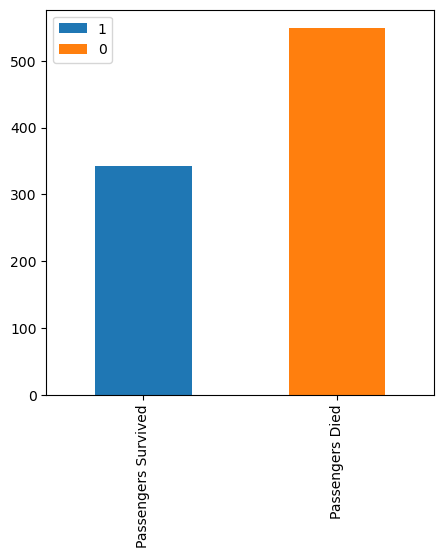

In [555]:
bar_chart_stacked(df, "Survived")

#### Observation:
As expected the majority of passengers in the training data died. 
Only 38% survived the disaster. So the training data suffers from data imbalance.

## 2.2 Analyze Feature Gender:

In [556]:
df['Sex'].value_counts().to_frame()

Sex
male    577
female  314

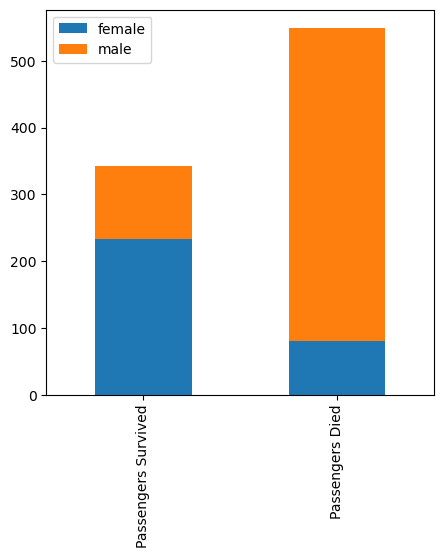

In [557]:
bar_chart_stacked(df, "Sex")

In [558]:
df.groupby('Sex').Survived.mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

### Observation:
Here, we can see the even though the majority of the passenger were male, the majority of survivors were female. The key observation here is that the survival rate for female passengers is 4 times higher than the survival rate of male passengers.   

## 2.3 Analyze Feature Pclass:

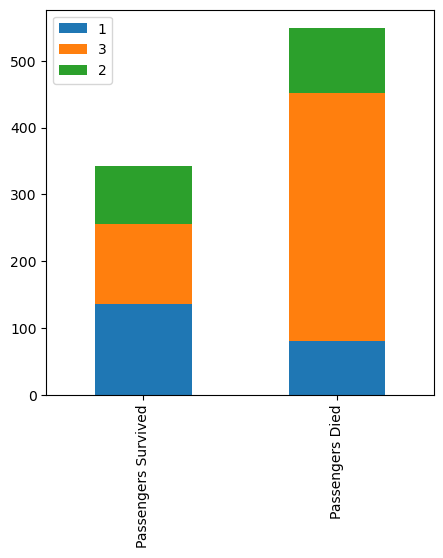

In [559]:
bar_chart_stacked(df, 'Pclass')

In [560]:
pd.pivot_table(df, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count')

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119

In [561]:
df.groupby(['Pclass']).Survived.mean().to_frame()

Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363

### Observation:
From the plots and tables above it becomes clear that the Pclass is an important factor to consider.

- Most passenger had class 3 tickets, yet only 24% of class 3 passengers survived.
- Almost 63% of the passenger from class 1 survived. 
- Also approx 50% of the class 2 passenger survived.

## 2.4 Analyze Feature Pclass With Gender:

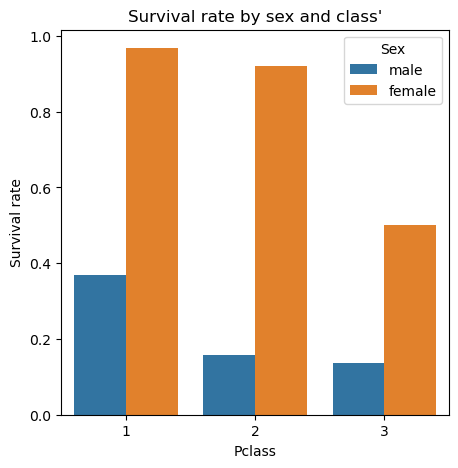

In [562]:
bar_chart_compare(df, "Pclass", "Sex")

In [563]:
pd.pivot_table(df, index = 'Survived', columns = ['Pclass', "Sex"], values = 'Ticket' ,aggfunc ='count')

Pclass        1           2           3     
Sex      female male female male female male
Survived                                    
0             3   77      6   91     72  300
1            91   45     70   17     72   47

In [564]:
df.groupby(['Pclass', "Sex"]).Survived.mean().to_frame()

Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

### Observation:
Here, we can clearly see that irrespective of the class the most important factor when it comes to surviving was gender. (At least between Sex and Pclass).
However, men in class 1 had a significantly higher chance of survival when they bought class 1 tickets.
This just shows to say that we should keep both features as both yield insightful information that should help our model.
- Survival Rate females 1. Class: 96,8%
- Survival Rate females 2. Class: 92,1%
- Survival Rate females 3. Class: 50% 

- Survival Rate male 1. Class: 36.8%
  <br>(still significantly lower than 3. class females)
    



## 2.5 Analyze Feature Age:

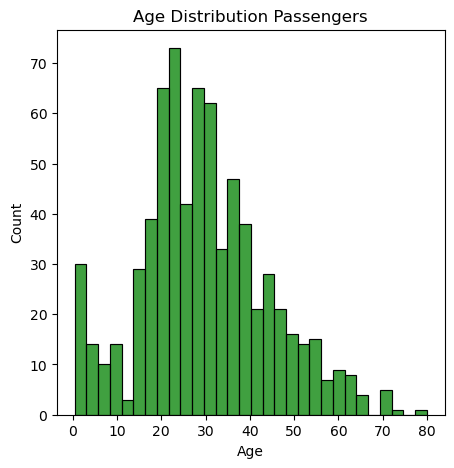

In [565]:
plot_distribution(df, "Age", "Age Distribution Passengers")

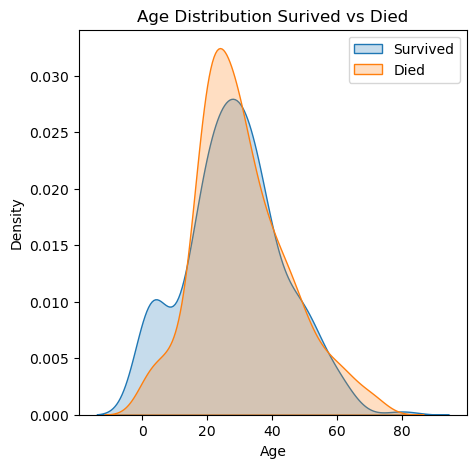

In [566]:
plot_kernel_density_estimate_survivors(df, "Age", "Age Distribution Surived vs Died")

### Observation:
The Histogram above shows that age follows a fairly normal distribution.

Also investigating the kernel density estimate does not provide additional information except a raise in survivors at a very young age.

## 2.6 Analyze FeatureFeature Age & Sex together:

In [567]:
def plot_swarm_survivors(dataset, feature1, feature2, title, fize = (155)):
    fig, ax = plt.subplots(figsize=(18,5))
    # Turns off grid on the left Axis.
    ax.grid(True)
    plt.xticks(list(range(0,100,2)))
    sns.swarmplot(y=feature1, x=feature2, hue='Survived',data=dataset).set_title(title)

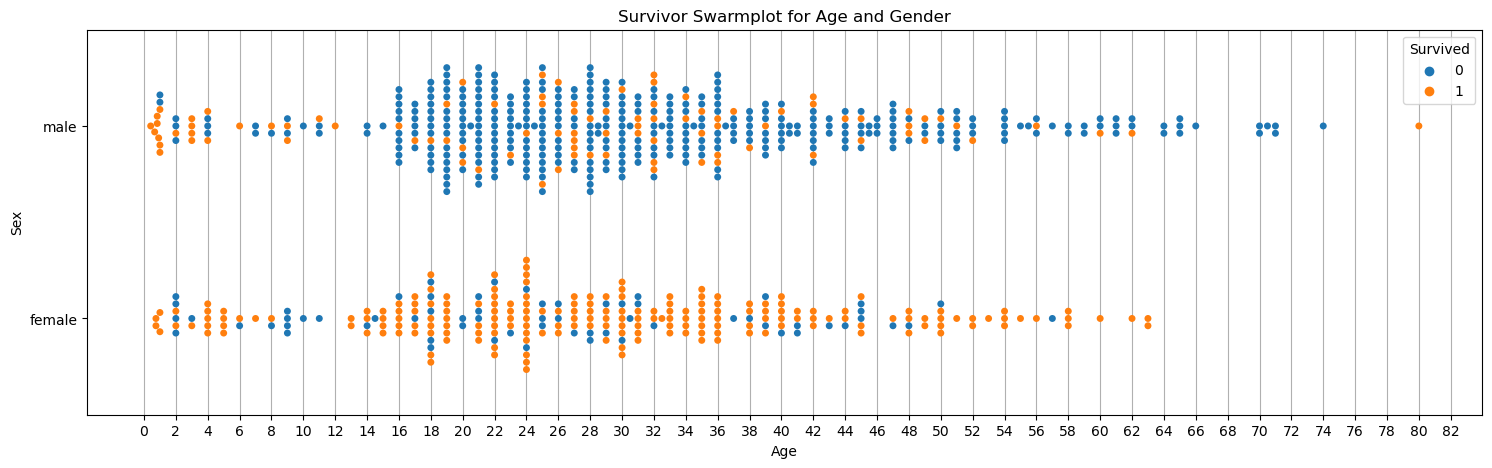

In [568]:
plot_swarm_survivors(df, "Sex", "Age", "Survivor Swarmplot for Age and Gender")

### Observation:
As expected age holds valuable information. The swarm plot above shows that a big portion of male survivors are passengers between 0 and 12 years of age.
It's also interesting to see that the oldest passenger 80 year old man survived.

## 2.7 Analyze Feature Fare:

In [569]:
df.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

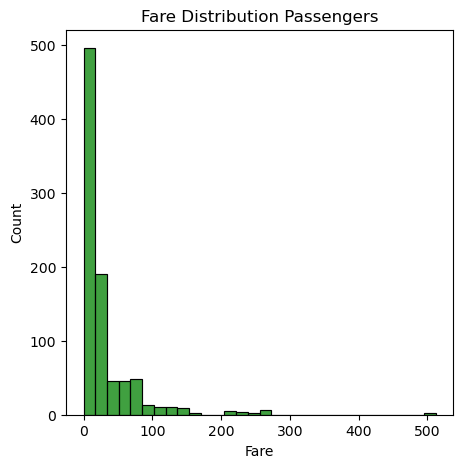

In [570]:
plot_distribution(df, "Fare", "Fare Distribution Passengers")

### Observation:
Fare does not follow a normal distribution and has a huge spike at the price range [0-100$].

To better understand how this feature influences the survival rate, we could plot bar plots of Fare vs Survived. However, due to the large range of fares such as plot would not be useful for inferring useful information. 

A more suited visualization would be to combine fares into categories and then plot the 
categories vs Survived. 

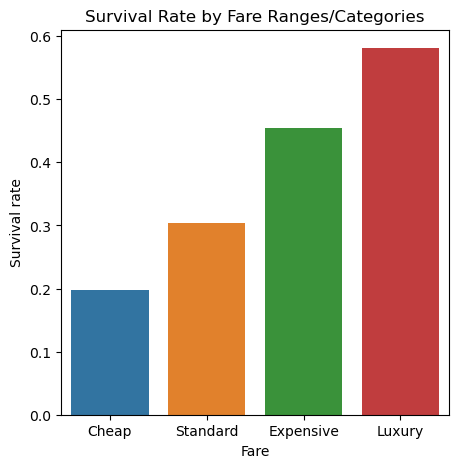

In [571]:
categories = ['Cheap', 'Standard', 'Expensive', 'Luxury']

plot_quartiles(df, "Fare", "Survival Rate by Fare Ranges/Categories", categories)

### Observation:
As we can see the likelihood of survival is definitely influenced by the price paid. 
- Cheap (0-25% of max Price): Surival Rate = 0.2 (aprox)
- Cheap (25%-50% of max Price): Surival Rate = 0.3 (aprox)
- Cheap (50%-75% of max Price): Surival Rate = 0.45 (aprox)
- Cheap (75%-100% of max Price): Surival Rate = 0.55 (aprox)



## 2.8 Analyze Feature Embarked

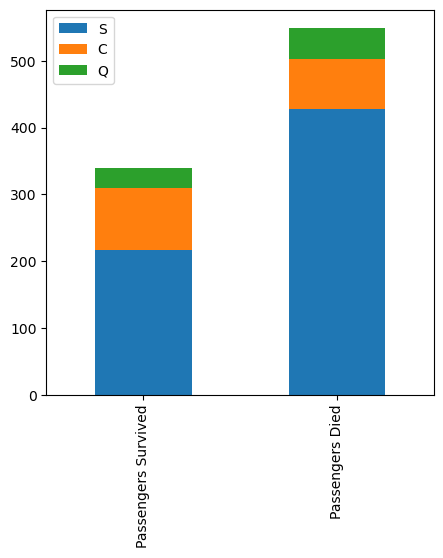

In [572]:
bar_chart_stacked(df, 'Embarked') 

In [573]:
df['Embarked'].value_counts().to_frame()

Embarked
S       644
C       168
Q        77

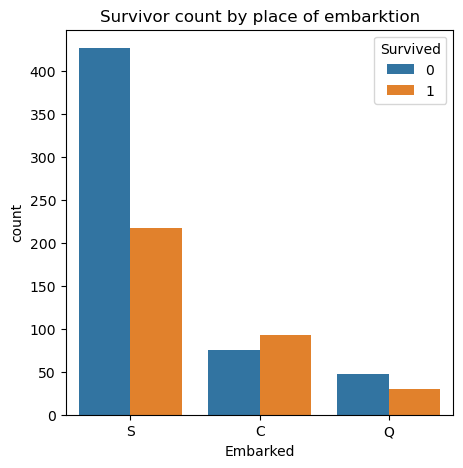

In [574]:
show_compare_countplot(df, "Embarked", "Survived", "Survivor count by place of embarktion")

In [575]:
pd.pivot_table(df, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count')

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217

In [576]:
df.groupby(['Embarked']).Survived.mean().to_frame()

Survived
Embarked          
C         0.553571
Q         0.389610
S         0.336957

### Observation:
There are three possible values for the Embarked Feature: 
- Southampton, Cherbourg, and Queenstown.

We can see that the majority of passengers embarked from Southampton.
However, only 33% survived the sinking of the titanic.

The highest survival rate of 55% is in the group of passengers that embarked from Cherbourg

Maybe this is because the Class 1 passengers embarked from Cherbourg. 

## 2.9 Analyze Features Embarked & Pclass together

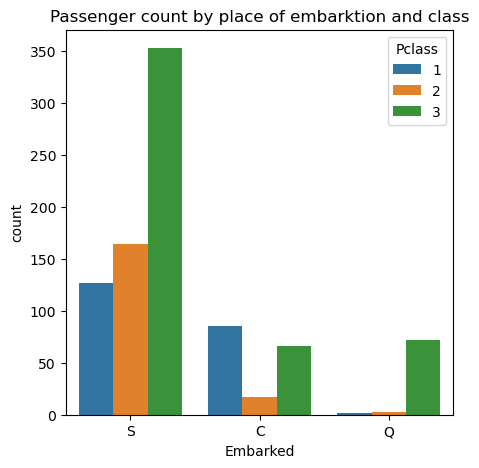

In [577]:
show_compare_countplot(df, "Embarked", "Pclass", "Passenger count by place of embarktion and class")

In [578]:
df.groupby(['Embarked', 'Pclass']).Survived.sum().to_frame()

Survived
Embarked Pclass          
C        1             59
         2              9
         3             25
Q        1              1
         2              2
         3             27
S        1             74
         2             76
         3             67

### Observation:
- The majority embarked at Cherbourg were 1. class passengers.
- The majority embarked at Southampton were 3. class passengers.

However, it does not explain why the survival rate at Queenstown is slightly higher than at Southampton even though the number of 1. class passenger concerning 3. class passengers is higher at Southampton. Let us explore the gender too.

## 2.10 Analyze Features Embarked & Sex together

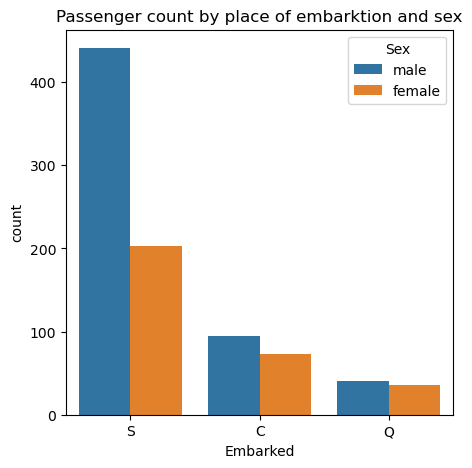

In [579]:
show_compare_countplot(df, "Embarked", "Sex", "Passenger count by place of embarktion and sex")

### Observation:
Twice as many male passengers embarked from Southam were roughly the same number of male and female passengers embarked from Queenstown. This just shows the importance of the Sex feature.

## 2.11 Analyze Feature SibSp:
SibSp is the number of siblings or spouses of a person aboard the Titanic

In [580]:
df['SibSp'].value_counts().to_frame()

SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5

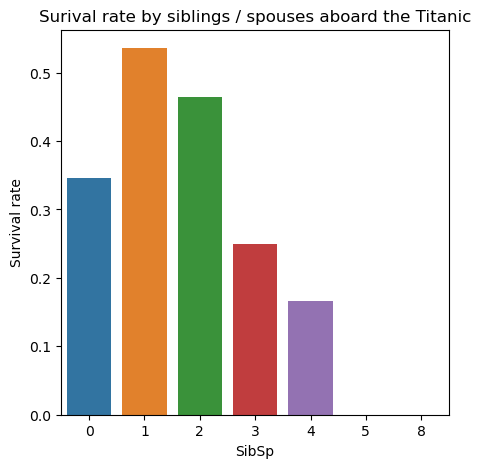

In [581]:
bar_chart_compare(df, "SibSp", title = "Surival rate by siblings / spouses aboard the Titanic")

In [582]:
df.groupby(['SibSp']).Survived.mean().to_frame()

Survived
SibSp          
0      0.345395
1      0.535885
2      0.464286
3      0.250000
4      0.166667
5      0.000000
8      0.000000

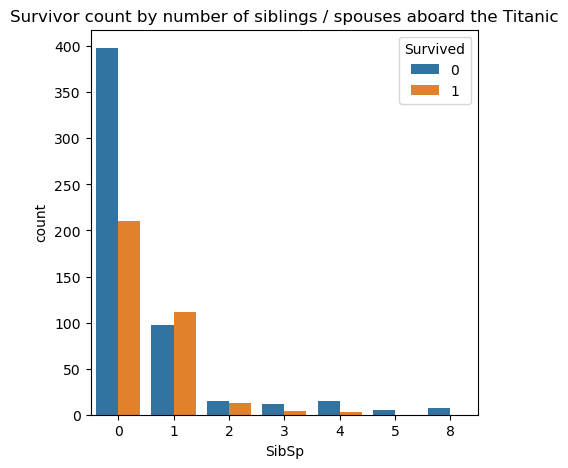

In [583]:
show_compare_countplot(df, "SibSp", "Survived", "Survivor count by number of siblings / spouses aboard the Titanic")

### Observarion:
The majority traveled alone.
It seems that the more Sibling a passenger has the less chance of survival there is.

##  2.12 Analyze Feature Parch

This feature contains the number of parents or children each passenger was traveling with.

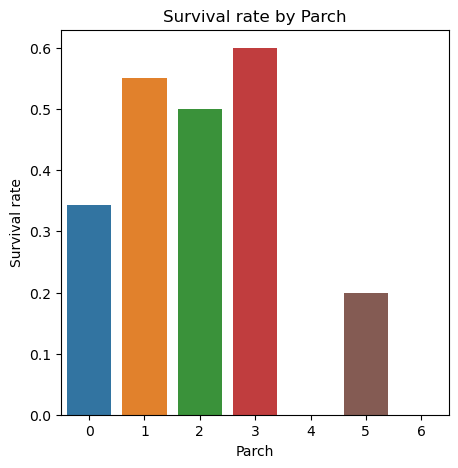

In [584]:
bar_chart_compare(df, "Parch", title = "Survival rate by Parch")

In [585]:
df.groupby(['Parch']).Survived.mean().to_frame()

Survived
Parch          
0      0.343658
1      0.550847
2      0.500000
3      0.600000
4      0.000000
5      0.200000
6      0.000000

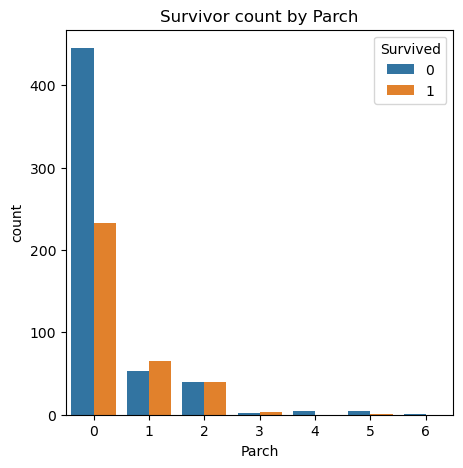

In [586]:
show_compare_countplot(df, "Parch", "Survived", "Survivor count by Parch")

### Observation:
This feature contains the number of parents or children each passenger was traveling with.
We see again that small families had more chances to survive than bigger ones and passengers who traveled alone.

For faster training, it might be beneficial to combine both features into 1 and create a family size feature.

## 2.2 Rank Feature Importance

### Remove insignificant columns

In [587]:
y = df['Survived'] 
X = df.drop(["Survived"], axis=1)
X = X.drop(["PassengerId"], axis=1)
X = X.drop(["Name"], axis=1)
X = X.drop(["Ticket"], axis=1)
X = X.drop(["Cabin"], axis=1)


### Missing Values

In [588]:
print(X.isnull().sum())

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


### Impute missing values with Mean for 'Age'

In [589]:
X['Age'] = X['Age'].replace(np.NaN, X['Age'].median())

### Impute missing values with 'U' for 'Embarked'

In [590]:
X['Embarked'] = X['Embarked'].replace(np.NaN, 'U')

In [591]:
print(X.isnull().sum())

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


### Map to numeric values

In [592]:
X['Sex'] = X['Sex'].map({'male':1,'female':0})
X['Embarked'] = X['Embarked'].map({'S':0,'C':1,'Q':2,'U':-1 })
X.head()

Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0       3    1  22.0      1      0   7.2500         0
1       1    0  38.0      1      0  71.2833         1
2       3    0  26.0      0      0   7.9250         0
3       1    0  35.0      1      0  53.1000         0
4       3    1  35.0      0      0   8.0500         0

### Feature Importance

[0.10805052 0.29242547 0.24309753 0.0444382  0.04173822 0.2389325
 0.03131756]


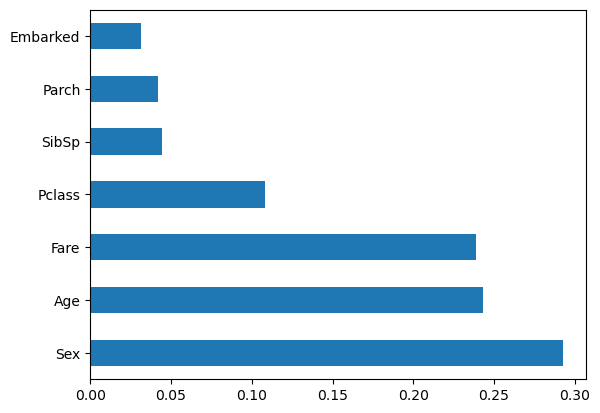

In [593]:
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

We see that the features are ranked as follows: Sex, Fare, Age, Pclass, SibSp, Parch, Embraked

# 3. Feature engineering

## 3.1 Feature Name:

### Observation
To create a new feature we can extract the Titles from the name.

In [594]:
df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [595]:
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked Title  
0      0         A/5 21171   7.2500   NaN        S    Mr  
1      0          PC 17599  71.2833   C85        C   Mrs  
2      0  STON/O2. 3101282   7.9250   NaN        S  Miss  
3      0            113803  53.1000  C123        S   Mrs  
4      0            373450   8.0500   NaN        S    Mr

In [596]:
df['Title'].value_counts().to_frame()

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1

### Observation:
The titles are severely imbalanced. Let us group less frequent Titles together by substituting male titles into Mr and female Titles into Miss.

In [597]:
df['Title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Miss', inplace=True)
df['Title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer'], 'Mr', inplace=True)

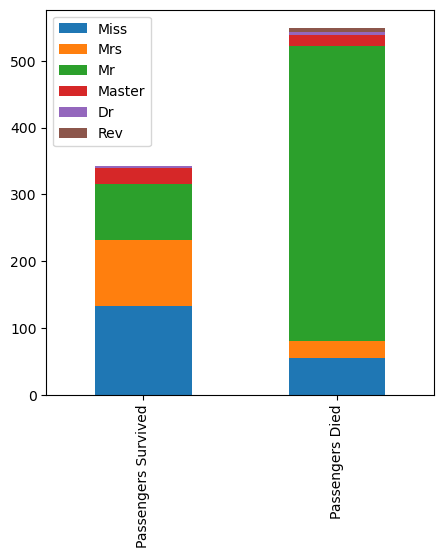

In [598]:
bar_chart_stacked(df, 'Title') 

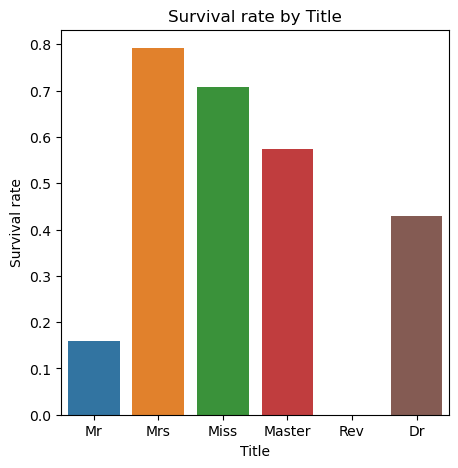

In [599]:
bar_chart_compare(df, "Title", title = "Survival rate by Title")

### Observation:
- Female Titles result in a higher survival rate.
- Master and Dr are slightly have a surprisingly high survival rate even tough both are male titles
- Being only a Mr comes with a compromised survival rate of approx 15%
- All 6 Revernands died. Maybe religious reasons caused them to sacrifice their lives for others.

## 3.2 Feature Family Size
For faster training, it might be beneficial to combine both features into 1 and create a family size feature.

In [600]:
df['Fam_size'] = df['SibSp'] + df['Parch'] + 1

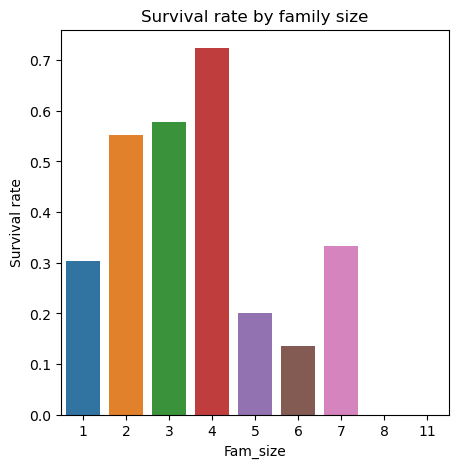

In [601]:
bar_chart_compare(df, "Fam_size", title = "Survival rate by family size")

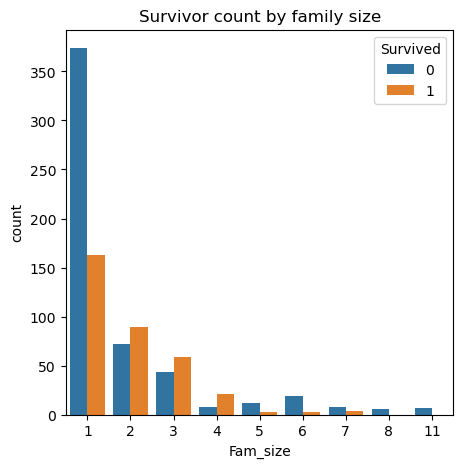

In [602]:
show_compare_countplot(df, "Fam_size", "Survived", "Survivor count by family size")

## 3.3 Feature Family Type
To further summarize the previous trend, as our final feature, Let's create four groups for family size

In [603]:
# Creation of four groups
df['Fam_type'] = pd.cut(df.Fam_size, [0,1,4,7,11], labels=['Solo', 'Small', 'Big', 'Very big'])
df['Fam_type'] = pd.cut(df.Fam_size, [0,1,4,7,11], labels=['Solo', 'Small', 'Big', 'Very big'])

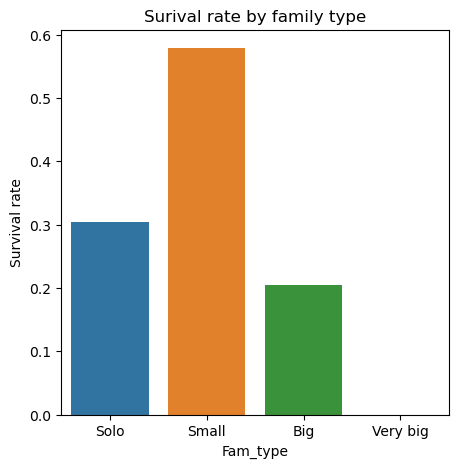

In [604]:
bar_chart_compare(df, "Fam_type", title = "Surival rate by family type")

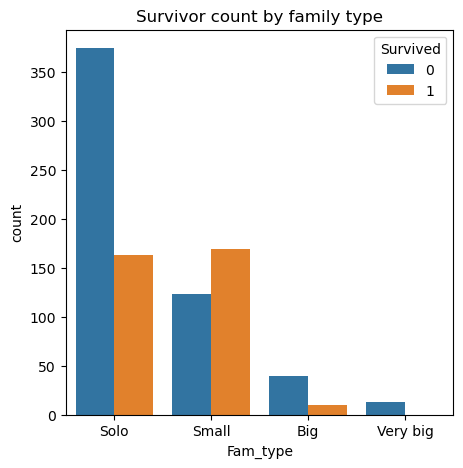

In [605]:
show_compare_countplot(df, "Fam_type", "Survived", "Survivor count by family type")

# 4. Training a classifier

- We start by selecting the features we will use and isolating the target.
- We will not consider PassengerId, Name, Ticket and Cabin
- We did not SibSp, Parch, instead we will use 'Fam_type'.
- We also did not use Sex as it is not useful given the Title column:<br> 
  adult males and young children have the same sex but are different categories as we saw before, so we don't want to confuse our algorithm.


In [606]:
X.head()

Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0       3    1  22.0      1      0   7.2500         0
1       1    0  38.0      1      0  71.2833         1
2       3    0  26.0      0      0   7.9250         0
3       1    0  35.0      1      0  53.1000         0
4       3    1  35.0      0      0   8.0500         0

In [607]:
features = ['Pclass', 'Age', 'Fare', 'Embarked']
X = X[features]
X['Title']=df['Title']
X['Fam_type']=df['Fam_type']
X.head()

Pclass   Age     Fare  Embarked Title Fam_type
0       3  22.0   7.2500         0    Mr    Small
1       1  38.0  71.2833         1   Mrs    Small
2       3  26.0   7.9250         0  Miss     Solo
3       1  35.0  53.1000         0   Mrs    Small
4       3  35.0   8.0500         0    Mr     Solo

## 4.1 Missing Values

In [608]:
print(X.isnull().sum())

Pclass      0
Age         0
Fare        0
Embarked    0
Title       0
Fam_type    0
dtype: int64


## One-Hot Encoding of Categorical Column Using Pandas library

In [609]:
one_hot_encoded_data = pd.get_dummies(X, columns = ['Title', 'Fam_type', 'Embarked']) 
print(one_hot_encoded_data)

     Pclass   Age     Fare  Title_Dr  Title_Master  Title_Miss  Title_Mr  \
0         3  22.0   7.2500         0             0           0         1   
1         1  38.0  71.2833         0             0           0         0   
2         3  26.0   7.9250         0             0           1         0   
3         1  35.0  53.1000         0             0           0         0   
4         3  35.0   8.0500         0             0           0         1   
..      ...   ...      ...       ...           ...         ...       ...   
886       2  27.0  13.0000         0             0           0         0   
887       1  19.0  30.0000         0             0           1         0   
888       3  28.0  23.4500         0             0           1         0   
889       1  26.0  30.0000         0             0           0         1   
890       3  32.0   7.7500         0             0           0         1   

     Title_Mrs  Title_Rev  Fam_type_Solo  Fam_type_Small  Fam_type_Big  \
0            

## Train - Test Split

In [610]:
X_train, X_test, y_train, y_test = train_test_split(one_hot_encoded_data, y, test_size=0.25, random_state=42)

## Training a classifier

In [611]:
model = RandomForestClassifier(random_state=0, n_estimators=500, max_depth=5)
model.fit(X_train,y_train)

print('Cross validation score: {:.3f}'.format(cross_val_score(model, X_train, y_train, cv=10).mean()))

Cross validation score: 0.828


In [612]:
y_pred = model.predict(X_test)

In [613]:
overall_model_eval(y_test, y_pred)   

Accuracy: 0.8295964125560538
F1 Score: 0.8280565335902347
Precision: 0.8287636464861248
Recall: 0.8295964125560538


(0.8295964125560538,
 0.8280565335902347,
 0.8287636464861248,
 0.8295964125560538)

We used the random forest classifier to predict if a traveller survived or not. We get a good accuracy of about 83%.